# Relevance Classification Models V2

A series of modifications are made to the classification models in this notebook. The potential improvements being tested are:

- Inclusion of bi and trigrams
- Inclusion of POS tagged tokens
- More model types

**Scikit learn n-grams**
- CountVectorizer with ngrams 1 - n
- Tf-idf
- SVD (sklearn/gensime/jakevdp method)

**Scikit learn n-grams**
- CountVectorizer with ngrams 1 - n
- Convert to gensim corpus
- SVD gensim

**Gensim n-grams**
- Build grams up to n
- Add n-grams onto original document by concatenating lists and dropping terms already in text

**Separate ngram corpora**
- Create separate bi and trigram corpora with gensim
- ML on all three and combine

** Split text into all possibel n-grams**
- Use ALL ngrams
- (is this what sklearn does anyway?)

** Count Vectorizer **
- Same as methods above but with no Tf-Idf

In [1]:
import pandas as pd
import numpy as np
import re
import string
from langdetect import detect
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
# from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.externals import joblib

import gensim
from gensim.models.phrases import Phraser
from gensim.models import Phrases

import pandas.io.sql as psql
import psycopg2 as pg

#import matplotlib.pyplot as plt
#import seaborn as sns
from gensim.sklearn_integration.sklearn_wrapper_gensim_lsimodel import SklLsiModel
from gensim.sklearn_integration.sklearn_wrapper_gensim_ldamodel import SklLdaModel
import pycountry
import unicodedata

#%matplotlib inline

In [2]:
pd.options.display.max_columns = 999

In [3]:
import spacy
nlp = spacy.load('en_default')

In [4]:
from idetect.geotagger import strip_accents, compare_strings, strip_words, common_names, LocationType
from idetect.geotagger import subdivision_country_code, match_country_name, city_subdivision_country

## Training Data

- Import training data
- Filter to English only

In [5]:
with open('../data/stop_words_en_long.txt', 'r') as f:
    stop_words = f.read()
stop_words = stop_words.split('\n')

## Preprocessing

### Example Texts

For quick testing purposes, a single example sentence, and a list of example sentences are defined.

In [6]:
# example_text = 'Flooding has stranded many people. 100 families fled across the border.'
example_text = ['At least 6171 people in London were forced to evacuate homes, including more than 2600 staying in emergency shelters']

In [7]:
example_sentences = [u'Flooding has stranded many peole100 families were evacuated by the army.',
                     u'Some people have fled to safety from the wild fire.',
                     u'Flooding has stranded more people in nearby London.',
                     u'It was all going ok but now flooding has stranded them.']

In [8]:
example_sentence = """At least six thousand people were forced to evacuate homes, including more than 2600 staying in emergency shelters, according to Taiwan's Central Emergency Operation Center. Taiwanese weather authorities lifted sea and land warnings on Thursday as Trami blew away from the island. Tell us more at jon@disasters.com."""

In [9]:
doc = nlp(example_sentence)
docs = [nlp(sent) for sent in example_sentences]

### Cleaning Processor

The Cleaner class replaces commonly enountered errors in the texts that have been manually identified.

In [7]:
class CleaningProcessor(BaseEstimator, TransformerMixin):
    """Transformer that turns documents in string form
    into token lists, with various processing steps applied.
    
    Parameters
    ----------
    pos_tags : bool, required
        Whether to tag words with their part of speech labels.
    lemmatize : bool, required
        Whether to lemmatize tokens.
    stop_words : book, required
        Whether to remove stop words.
    """
        
    def cleanup(self, text):
        """
        Cleanup text based on commonly encountered errors.
        param: text     A string
        return: A cleaned string
        """
        text = re.sub(r'([a-zA-Z0-9])(IMPACT)', r'\1. \2', text)
        text = re.sub(r'([a-zA-Z0-9])(RESPONSE)', r'\1. \2', text)
        text = re.sub(r'(IMPACT)([a-zA-Z0-9])', r'\1. \2', text)
        text = re.sub(r'(RESPONSE)([a-zA-Z0-9])', r'\1. \2', text)
        text = re.sub(r'([a-z])([A-Z]{2,})', r'\1 \2', text)
        text = re.sub(r'([a-zA-Z])(\d)', r'\1. \2', text)
        text = re.sub(r'(\d)\s(\d)', r'\1\2', text)
        text = text.replace('\r', ' ')
        text = text.replace('  ', ' ')
        text = text.replace('\n', ' ')
        text = text.replace("peole", "people")

        output = ''
        for char in text:
            if char in string.printable:
                output += char
        return output
    
    def tag_entities(self, text):
        tokens = []
        for token in text:
            if token.ent_type_ == 'GPE':
                if match_country_name(token.text)[0]:
                    tokens.append('Switzerland')
                elif city_subdivision_country(token.text):
                    tokens.append('Zurich')
                else:
                    tokens.append('Zurich')
            elif token.like_num:
                tokens.append('1000')
            elif token.like_url:
                continue
            elif token.like_email:
                continue
            else:
                tokens.append(token.text)
        return tokens

    def join_phrases(self, phrases):
        joined = []
        for phrase in phrases:
            tokens = []
            for token in phrase:
                if isinstance(token, spacy.tokens.token.Token):
                    tokens.append(token.lemma_)
                else:
                    tokens.append(token)
            if len(tokens) < 2:
                continue
            joined.append('_'.join(tokens))
        return joined
    
    def single_string(self, texts):
        strings = [' '.join(t) for t in texts]
        return strings
    
    def fit(self, texts, *args):
        return self
    
    def transform(self, texts, *args):
        texts = [self.cleanup(t) for t in texts]
        texts = [nlp(t) for t in texts]
        texts = [self.tag_entities(t) for t in texts]
        texts = self.single_string(texts)
        return texts

In [11]:
cleaner = CleaningProcessor()

In [12]:
cleaner.fit_transform(example_sentences)

['Flooding has stranded many people . 1000 families were evacuated by the army .',
 'Some people have fled to safety from the wild fire .',
 'Flooding has stranded more people in nearby Zurich .',
 'It was all going ok but now flooding has stranded them .']

### Phrase Processor

There is often significant vocabulary overlap between articles of different categories. However, the phrases that describe actual events are often different. The `Phraser` attempts to extract small snippets of phrases from the text in the hope that they may be common within a class. 

In [6]:
class PhraseProcessor(BaseEstimator, TransformerMixin):
    """Transformer that turns documents in string form
    into token lists, with various processing steps applied.
    
    Parameters
    ----------
    pos_tags : bool, required
        Whether to tag words with their part of speech labels.
    lemmatize : bool, required
        Whether to lemmatize tokens.
    stop_words : book, required
        Whether to remove stop words.
    """
    
    def __init__(self, stop_words):
        self.stop_words = stop_words
    
    def parse_phrases(self, doc):
        '''Return a list of lists, with each sublist containing a token from the text,
        it's parent token and it's grandparent token. Does not return any repeat tokens
        in each phrase.'''
        phrases = []
        for d in doc:
            if not d.is_punct:
                if d.head != d:
                    if d.head.head != d.head:
                        phrases.append([d, d.head, d.head.head])
                    else:
                        phrases.append([d, d.head])
        return phrases

    def join_phrases(self, phrases):
        joined = []
        for phrase in phrases:
            tokens = []
            for token in phrase:
                if isinstance(token, spacy.tokens.token.Token):
                    tokens.append(token.lemma_)
                else:
                    tokens.append(token)
            if len(tokens) < 2:
                continue
            joined.append('_'.join(tokens))
        return joined
    
    def single_string(self, texts):
        strings = [' '.join(t) for t in texts]
        return strings
    
    def fit(self, texts, *args):
        return self
    
    def transform(self, texts, *args):
#         import pdb; pdb.set_trace()
        docs = [nlp(t) for t in texts]
        phrases = [self.parse_phrases(d) for d in docs]
        joined = [self.join_phrases(p) for p in phrases]
        text = self.single_string(joined)
        return text

In [24]:
phraser = PhraseProcessor(stop_words)

In [25]:
processed_sentences = phraser.transform(example_sentences)
processed_sentence = phraser.transform(example_sentence)

### Part of Speech Tokenizer

This processor has options to label the tokens of a text with their part of speech (POS) tags, lemmatize them, and remove stop words. It also removes certain POS entities and words of length < 2.

In [8]:
class POSProcessor(BaseEstimator, TransformerMixin):
    """Transformer that turns documents in string form
    into token lists, with various processing steps applied.
    
    Parameters
    ----------
    pos_tags : bool, required
        Whether to tag words with their part of speech labels.
    lemmatize : bool, required
        Whether to lemmatize tokens.
    stop_words : book, required
        Whether to remove stop words.
    """
    
    def __init__(self, stop_words, pos_tags=True,
                rejoin=True):
        self.stop_words = stop_words
        self.pos_tags = pos_tags
        self.rejoin = rejoin

    def tag_pos(self, text):
        return [(t, t.pos_) for t in text]
    
    def get_lemmas(self, text):
        return [t[0].lemma_ for t in text]

    def remove_noise(self, text):
        noise_tags = ['DET', 'NUM', 'SYM']
        text = [t for t in text if t[0].text not in self.stop_words]
        text = [t for t in text if len(t[0]) > 2]
        text = [t for t in text if t[1] not in noise_tags]
        text = [t for t in text if ~t[0].like_num]
        return text
    
    def join_pos_lemmas(self, pos, lemmas):
        return ['{}_{}'.format(l, p[1]).lower() for p, l
                in zip(pos, lemmas)]
    
    def fit(self, texts, *args):
        return self
    
    def single_string(self, texts):
        strings = [' '.join(t) for t in texts]
        return strings
    
    def transform(self, texts, *args):
        docs = [nlp(sent) for sent in texts]
        docs = [self.tag_pos(d) for d in docs]
        docs = [self.remove_noise(d) for d in docs]
        lemmas = [self.get_lemmas(d) for d in docs]
        if self.pos_tags:
            docs = [self.join_pos_lemmas(d, l) for d, l
                    in zip(docs, lemmas)]
        if self.rejoin:
            docs = self.single_string(docs)
        return docs

In [28]:
pos_processor = POSProcessor(stop_words, rejoin=False)

In [29]:
pos_processor.fit_transform(example_sentences)

[['flooding_noun',
  'strand_verb',
  'peole100_adj',
  'family_noun',
  'evacuate_verb',
  'army_noun'],
 ['people_noun', 'flee_verb', 'safety_noun', 'wild_adj', 'fire_noun'],
 ['flooding_noun', 'strand_verb', 'people_noun', 'nearby_adj', 'london_propn'],
 ['go_verb', 'flooding_noun', 'strand_verb']]

### N-gram Processor

The n-gram processor identifies common word co-occurences of between 2 or 3 words.

In [21]:
class NGramProcessor(BaseEstimator, TransformerMixin):
    """Transformer that finds and returns common bi and tri-grams
    that appear in a text.
    
    Parameters
   ----------
    bi_min_count : int, required
        Minimum number of times a bi-gram must occur in the corpus
        to be counted.
    bi_threshold : int, required
        Threshold value used to calculate threshold scoring for 
        bi-grams to be counted. See gensim docs for more details.
    tri_min_count : int, required
        Minimum number of times a tri-gram must occur in the corpus
        to be counted.
    tri_threshold : int, required
        Threshold value used to calculate threshold scoring for 
        tri-grams to be counted. See gensim docs for more details.
    mode : 'str', required (default = 'trigram)
        If 'trigram+', then original text is returned with both bi 
        and tri-grams replacing corresponding tokens.
        If 'bigram+', then original text is returned with only bi-
        grams replacing corresponding tokens.
        If 'everything', then full original text is returned with all
        bi and tri-grams appended.
        If 'bigram
    """
    
    def __init__(self, bi_min_count=5, bi_threshold=10,
                 tri_min_count=5, tri_threshold=10,
                 mode='trigram'):
        self.pos_processor = POSProcessor(rejoin=False)
        self.bi_min_count = bi_min_count
        self.bi_threshold = bi_threshold
        self.tri_min_count = tri_min_count
        self.tri_threshold = tri_threshold
        self.mode = mode
    
    def fit(self, texts, *args):
        #docs = self.pre_processor.transform(texts)
        self.build_grammer(texts)
        return self
    
    def build_grammer(self, texts):
        """Creates bi and tri-gram Phraser models.
        """
        self.bigram = Phrases(texts, 
                          min_count=self.bi_min_count, 
                          threshold=self.bi_threshold)
        self.bigrammer = Phraser(self.bigram)
        if (self.mode=='trigram') | (self.mode=='trigram+') | (self.mode=='everything'):
            self.trigram = Phrases(self.bigrammer[texts], 
                              min_count=self.tri_min_count, 
                              threshold=self.tri_threshold)
            self.trigrammer = Phraser(self.trigram)

    def make_grams(self, text):
        """Applies Phraser models. Returns text with bigrams or trigrams replacing
        their corresponding tokens, or both bigrams and trigrams, plus all original tokens."""
        bigrams = self.bigrammer[text]
        if self.mode=='bigram':
            return bigrams
        elif (self.mode=='trigram') | (self.mode=='everything'):
            trigrams = self.trigrammer[bigrams]
            if self.mode=='trigram':
                return trigrams
            elif self.mode=='everything':
                trigrams = [t for t in trigrams if t not in bigrams]
                all_grams = bigrams + trigrams
                return all_grams
    
    def merge(self, text, ngrams):
        """Returns text where the original text is kept, and
        all n-grams are appended."""
        grams_only = [ng for ng in ngrams if ng not in list(set(text))]
        return text + grams_only
    
    def stringify(self, grams):
        gram_strs = []
        for g in grams:
            gram_strs.append(u' '.join(g))
        return gram_strs
    
    def transform(self, texts, *args):
        texts = self.pos_processor.fit_transform(texts)
        grams = [self.make_grams(d) for d in texts]
        if (self.mode=='bigram') | (self.mode=='trigram'):
            return self.stringify(grams)
        elif self.mode=='everything':
            grammed_text = [self.merge(d, ng) for d, ng
                            in zip(docs, grams)]
            return self.stringify(grammed_text)

In [22]:
grammer = NGramProcessor(bi_min_count=2, bi_threshold=1,
                 tri_min_count=1, tri_threshold=1,
                 mode='bigram')

In [23]:
grammer.fit(example_sentences)

NGramProcessor(bi_min_count=2, bi_threshold=1, mode='bigram', tri_min_count=1,
        tri_threshold=1)

In [24]:
grammed_text = grammer.transform(example_sentences)

In [25]:
grammed_text

['flooding_noun strand_verb peole100_adj family_noun evacuate_verb army_noun',
 'people_noun flee_verb safety_noun wild_adj fire_noun',
 'flooding_noun strand_verb people_noun nearby_adj london_propn',
 'go_verb flooding_noun strand_verb']

### LSI

In [9]:
from scipy import sparse
from gensim import matutils, models

class CustomSklLsiModel(SklLsiModel):
    """Gensim's Lsi model with sklearn wrapper, modified to handle sparse matrices 
    for both fit and transform. Makes the class compatible with sklearn's Tfidf and 
    Count vectorizers.
    """
    
    def sparse_2_tupes(self, sparse):
        """Converts sparse matrix into manageable tuple format."""
        for t in t_skltfidf:
            cx = t.tocoo()
            tups = []
            for i, j in zip(cx.col, cx.data):
                tups.append((i, j))
        return tups
    
    def fit(self, X, y=None):
        """
        Fit the model according to the given training data.
        Calls gensim.models.LsiModel
        """
        if sparse.issparse(X):
            corpus = matutils.Sparse2Corpus(X, documents_columns=False)
        else:
            corpus = X

        self.gensim_model = models.LsiModel(corpus=corpus, num_topics=self.num_topics, id2word=self.id2word, chunksize=self.chunksize,
            decay=self.decay, onepass=self.onepass, power_iters=self.power_iters, extra_samples=self.extra_samples)
        return self
    
    def transform(self, docs):
        """
        Takes a list of documents as input ('docs').
        Returns a matrix of topic distribution for the given document bow, where a_ij
        indicates (topic_i, topic_probability_j).
        The input `docs` should be in BOW format and can be a list of documents like : [ [(4, 1), (7, 1)], [(9, 1), (13, 1)], [(2, 1), (6, 1)] ]
        or a single document like : [(4, 1), (7, 1)]
        """
        if self.gensim_model is None:
            raise NotFittedError("This model has not been fitted yet. Call 'fit' with appropriate arguments before using this method.")

        # The input as array of array
        # import pdb; pdb.set_trace()
        # check = lambda x: [x] if isinstance(x[0], tuple) else x
        # docs = check(docs)
        if sparse.issparse(docs):
            docs = matutils.Sparse2Corpus(docs, documents_columns=False)
        X = [[] for i in range(0, len(docs))];
        for k,v in enumerate(docs):
            doc_topics = self.gensim_model[v]
            probs_docs = list(map(lambda x: x[1], doc_topics))
            # Everything should be equal in length
            if len(probs_docs) != self.num_topics:
                probs_docs.extend([1e-12]*(self.num_topics - len(probs_docs)))
            X[k] = probs_docs
            probs_docs = []
        return np.reshape(np.array(X), (len(docs), self.num_topics))

### LDA

In [28]:
class CustomSklLdaModel(SklLdaModel):
    """Gensim's Lsi model with sklearn wrapper, modified to handle sparse matrices 
    for both fit and transform. Makes the class compatible with sklearn's Tfidf and 
    Count vectorizers.
    """
    
    def sparse_2_tupes(self, sparse):
        """Converts sparse matrix into manageable tuple format."""
        for t in t_skltfidf:
            cx = t.tocoo()
            tups = []
            for i, j in zip(cx.col, cx.data):
                tups.append((i, j))
        return tups
    
    def fit(self, X, y=None):
        """
        Fit the model according to the given training data.
        Calls gensim.models.LsiModel
        """
        if sparse.issparse(X):
            corpus = matutils.Sparse2Corpus(X, documents_columns=False)
        else:
            corpus = X

        self.gensim_model = models.LdaModel(corpus=corpus, num_topics=self.num_topics, id2word=self.id2word,
            chunksize=self.chunksize, passes=self.passes, update_every=self.update_every,
            alpha=self.alpha, eta=self.eta, decay=self.decay, offset=self.offset,
            eval_every=self.eval_every, iterations=self.iterations,
            gamma_threshold=self.gamma_threshold, minimum_probability=self.minimum_probability,
            random_state=self.random_state)
        return self
    
    def transform(self, docs):
        """
        Takes a list of documents as input ('docs').
        Returns a matrix of topic distribution for the given document bow, where a_ij
        indicates (topic_i, topic_probability_j).
        The input `docs` should be in BOW format and can be a list of documents like : [ [(4, 1), (7, 1)], [(9, 1), (13, 1)], [(2, 1), (6, 1)] ]
        or a single document like : [(4, 1), (7, 1)]
        """
        if self.gensim_model is None:
            raise NotFittedError("This model has not been fitted yet. Call 'fit' with appropriate arguments before using this method.")

        # The input as array of array
        # import pdb; pdb.set_trace()
        # check = lambda x: [x] if isinstance(x[0], tuple) else x
        # docs = check(docs)
        if sparse.issparse(docs):
            docs = matutils.Sparse2Corpus(docs, documents_columns=False)
        X = [[] for i in range(0, len(docs))];
        for k, v in enumerate(docs):
            doc_topics = self.gensim_model[v]
            probs_docs = list(map(lambda x: x[1], doc_topics))
            # Everything should be equal in length
            if len(probs_docs) != self.num_topics:
                probs_docs.extend([1e-12]*(self.num_topics - len(probs_docs)))
            X[k] = probs_docs
        return np.reshape(np.array(X), (len(docs), self.num_topics))

### Two Countries

In [254]:
# TODO

## Model Building

## Relevance

### Data Prep

In [10]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [11]:
le = LabelEncoder()

In [12]:
df_rel = pd.read_csv('../data/training_data_clean_09242017.csv')

In [13]:
df_rel.head(1)

,Unnamed: 0,Unnamed: 0.1,is_displacement,category,text,is_displacement_label
0,11,37,yes,d,Fire authorities say a final figure of 1000 ho...,1


In [14]:
df_rel['is_displacement'].value_counts()

yes    634
no     365
Name: is_displacement, dtype: int64

In [15]:
df_rel['category'].value_counts()

d    864
c     84
o     42
b      9
Name: category, dtype: int64

In [16]:
def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'x'
    
def english_only(df):
    language = df['text'].apply(detect_lang)
    df = df[language == 'en']
    return df

In [17]:
# df = english_only(df)

In [18]:
df_rel['is_displacement_label'] = le.fit_transform(df_rel['is_displacement'])
df_rel_modeling = df_rel.sample(frac=1)

In [19]:
# cleaner = CleaningProcessor()
# df_rel_modeling['text'] = cleaner.fit_transform(df_rel_modeling['text'])

In [384]:
# df_rel_modeling.to_csv('../../data/training_data_clean_09242017.csv')

In [18]:
X_rel_train, X_rel_test, y_rel_train, y_rel_test = train_test_split(df_rel_modeling['text'], 
                                                    df_rel_modeling['is_displacement_label'],
                                                    test_size=0.2)

In [112]:
pos_processor = POSProcessor(stop_words)
phrase_processor = PhraseProcessor(stop_words)
pos_processor, phrase_processor = (pos_processor.fit(X_train), phrase_processor.fit(X_train))
X_train_pos, X_train_phrase = (pos_processor.transform(X_train), phrase_processor.transform(X_train))

In [113]:
X_test_pos, X_test_phrase = (pos_processor.transform(X_test), phrase_processor.transform(X_test))

In [114]:
X_train_all = []
for pos, phrase in zip(X_train_pos, X_train_phrase):
    X_train_all.append(pos + phrase)

X_test_all = []
for pos, phrase in zip(X_test_pos, X_test_phrase):
    X_test_all.append(pos + phrase)

### Corpus Statistics

In [206]:
# from collections import Counter
# import operator

In [214]:
# def splitter(x):
#     s = x.split(' ')
#     return s

# word_counter = Counter()
# for word in X_train.apply(splitter):
#     word_counter.update(word)
    
# sorted_x = sorted(word_counter.items(), key=operator.itemgetter(1),
#                   reverse=True)
# len(sorted_x)

In [242]:
## Uncomment to see frequency of words in corpus

# sorted_x

### Preprocessing and Vectorising

In [45]:
vocab = ['leave', 'evacuate', 'homeless', 'forced', 'flee', 'fled', 'destroyed', 'destruction', 
         'submerged', 'wrecked', 'washed', 'away', 'devastated', 'under', 'water', 'underwater', 
         'inundated', 'camp', 'collapse', 'left', 'reconstruct', 'demolished', 'uninhabitable', 
         'border', 'across', 'refugee', 'shelter', 'crops', 'corn', 'rice', 'maize', 'wheat', 
         'field']
counter = CountVectorizer(vocabulary=vocab)

In [54]:
## Set number of Lsi topics here

num_topics = 50

processor = Pipeline([
               ('tfidf', TfidfVectorizer(norm='l2')),
               ('lsi', CustomSklLsiModel(num_topics=num_topics))
])

In [56]:
# processor = processor.fit(X_train)
processor_pos = processor.fit(X_train_pos)
# processor_phrase = processor.fit(X_train_phrase)
# processor_all = processor.fit(X_train_all)

### Lsi Vector Plot

In [50]:
def visualize_processor_vectors(X, y, processor):
    vecs = processor.transform(X)
    
    v0 = []
    v1 = []
    v2 = []
    v3 = []
    v4 = []
    for v in vecs:
        v0.append(v[0])
        v1.append(v[1])
        v2.append(v[2])
        v3.append(v[3])
        v4.append(v[4])

    df = pd.DataFrame(data={'v0': v0, 'v1': v1, 'v2': v2, 'v3':v3, 'v4': v4, 'category': y})
            
    sns.pairplot(df, hue="category", plot_kws={'alpha': 0.2})
    
    return df

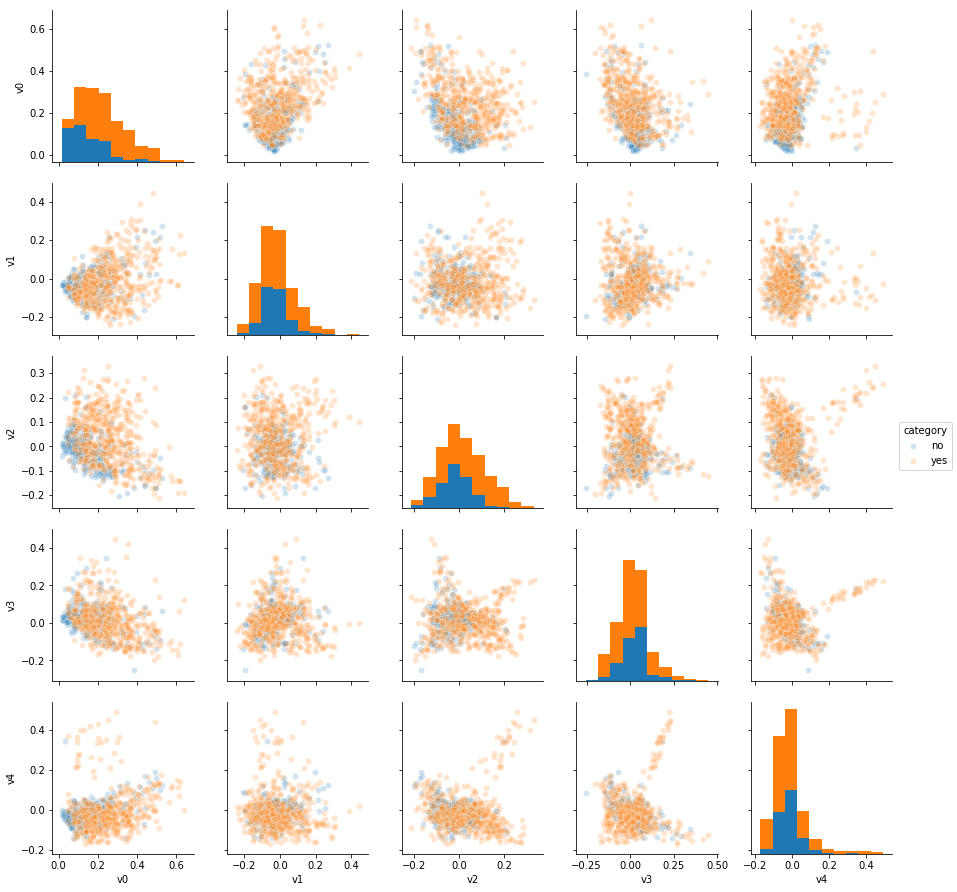

In [51]:
df = visualize_processor_vectors(X_train_pos, y_train, processor_pos)

### LSI Topic Investigation

In [57]:
# get vocabulary from tfidf to assess topics in LSI model
tfidf = processor.named_steps['tfidf']
id2word = {t[1]: t[0] for t in list(tfidf.vocabulary_.items())}
lsi_model = processor.named_steps['lsi'].gensim_model
lsi_model.id2word = id2word

In [58]:
lsi_model.print_topics()

[(0,
  '0.653*"zurich_propn" + 0.177*"people_noun" + 0.175*"switzerland_propn" + 0.158*"rain_noun" + 0.154*"flood_noun" + 0.118*"heavy_adj" + 0.117*"area_noun" + 0.111*"flooding_noun" + 0.098*"home_noun" + 0.096*"house_noun"'),
 (1,
  '0.528*"zurich_propn" + -0.218*"switzerland_propn" + -0.199*"flood_noun" + -0.176*"water_noun" + -0.120*"flooding_noun" + 0.118*"house_noun" + -0.117*"people_noun" + -0.108*"home_noun" + 0.108*"response" + -0.107*"displace_verb"'),
 (2,
  '-0.197*"displace_verb" + -0.181*"family_noun" + -0.180*"house_noun" + -0.172*"provide_verb" + -0.148*"relief_noun" + -0.144*"food_noun" + 0.138*"rain_noun" + -0.124*"assistance_noun" + 0.123*"hour_noun" + -0.118*"idp_noun"'),
 (3,
  '0.394*"fire_noun" + -0.197*"rain_noun" + 0.195*"burn_verb" + -0.192*"flood_noun" + -0.170*"heavy_adj" + -0.145*"flooding_noun" + 0.105*"idp_noun" + 0.105*"wildfire_noun" + -0.100*"rainfall_noun" + 0.095*"firefighter_noun"'),
 (4,
  '0.233*"displace_verb" + 0.208*"idp_noun" + 0.184*"zurich_p

### Feature Resolving Power

### Models

The models chosen are all capable of multiclass classification.

In [20]:
n_jobs = -1

rf_clf = RandomForestClassifier(n_jobs=n_jobs)

knn_clf = KNeighborsClassifier(n_jobs=n_jobs)

svm_clf = LinearSVC()

gnb_clf = GaussianNB()

lr_clf = LogisticRegression(multi_class='ovr')

### Simple Mode

Simple mode means transforming all of the features once for all of the classifiers. This has the advantage of speed, but the disadvantage of not tuning the input features for each classifier.

### LSI

In [21]:
lsi_pipe = Pipeline([
    ('union', FeatureUnion(transformer_list=[
        ('phrase', Pipeline([
            ('processor', PhraseProcessor(stop_words)),
            ('tfidf', TfidfVectorizer(max_features=20000)),
            ('lda', CustomSklLsiModel(num_topics=300))
        ])),
        ('pos', Pipeline([
            ('processor', POSProcessor(stop_words)),
            ('tfidf', TfidfVectorizer(max_features=20000, max_df=0.7)),
            ('lda', CustomSklLsiModel(num_topics=300))
        ]))
    ]))
])

In [ ]:
# lsi_pipe = joblib.load(lsi_pipe, 'lsi_union_10022017.pkl')

In [21]:
lsi_vecs_rel_train = lsi_pipe.fit_transform(X_rel_train)
lsi_vecs_rel_test = lsi_pipe.transform(X_rel_test)

In [22]:
lsi_vecs_rel_all = lsi_pipe.fit_transform(df_rel_modeling['text'])

In [244]:
# joblib.dump(lsi_pipe, 'lsi_union_10022017.pkl')

['lsi_union_10022017.pkl']

In [29]:
union = lsi_pipe.named_steps['union']
tfidf = union.transformer_list[1][1].named_steps['tfidf']

In [30]:
tfidf.vocabulary_

{'extent_noun': 2680,
 'kalaba_propn': 3975,
 'home_verb': 3449,
 'reconstruction_propn': 6120,
 'nhial_propn': 5080,
 'refuse_verb': 6153,
 'sensitisation_noun': 6688,
 'site_noun': 6889,
 'count_verb': 1775,
 'individual_noun': 3666,
 'skynewsaust_propn': 6914,
 'payment_noun': 5524,
 'associate_verb': 603,
 'wanganui_propn': 8149,
 'combination_noun': 1528,
 'labour_noun': 4147,
 'monument_noun': 4841,
 'loaf_noun': 4356,
 'southeast_noun': 7019,
 'this_propn': 7546,
 'deluge_noun': 2053,
 'takuya_propn': 7412,
 'southland_propn': 7025,
 'migrant_adj': 4721,
 'spent_verb': 7059,
 'hammad_propn': 3291,
 'doyle_propn': 2296,
 'affectedlocal_adj': 259,
 'apocalyptic_adj': 487,
 'coordinate_verb': 1735,
 'seismic_adj': 6656,
 'frontline_noun': 2984,
 'quality_propn': 5983,
 'phon_propn': 5604,
 'impact': 3604,
 'lift_verb': 4299,
 'bosso_propn': 977,
 'southern_adj': 7022,
 'express_verb': 2675,
 'study_noun': 7225,
 'step_verb': 7151,
 'circle_verb': 1405,
 'administrator_propn': 227,


### SVM Linear

In [22]:
svm = LinearSVC()
svm_params = {'C': [0.03, 0.1, 0.3, 1, 3, 10]}
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring=None, n_jobs=-1, verbose=1)

In [23]:
svm_grid.fit(lsi_vecs_rel_train, y_rel_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.03, 0.1, 0.3, 1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [33]:
svm_best = svm_grid.best_estimator_
svm_best

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [35]:
svm_preds = svm_best.predict(lsi_vecs_rel_test)
print(classification_report(y_rel_test, svm_preds))

             precision    recall  f1-score   support

          0       0.81      0.78      0.80        73
          1       0.88      0.90      0.89       127

avg / total       0.85      0.85      0.85       200



In [23]:
svm_final = LinearSVC(C=1)

In [26]:
svm_final.fit(lsi_vecs_rel_all, df_rel_modeling['is_displacement_label'])

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [27]:
svm_pipe = Pipeline([
    ('cleaner', CleaningProcessor()),
    ('lsi', lsi_pipe),
    ('svm', svm_final)
])

In [28]:
joblib.dump(svm_pipe, 'relevance_classifier_svm_10052017.pkl')

['relevance_classifier_svm_10052017.pkl']

### Logistic Regression

In [53]:
lr_params = {'C': [0.03, 0.1, 0.3, 1, 3, 10]}
lr_grid = GridSearchCV(lr_clf, lr_params, cv=5, scoring=None, n_jobs=-1, verbose=1)

In [55]:
lr_grid.fit(lsi_vecs_rel_train, y_rel_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.03, 0.1, 0.3, 1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [57]:
lr_best = lr_grid.best_estimator_
lr_preds = lr_best.predict(lsi_vecs_test)
print(classification_report(y_rel_test, lr_preds))

             precision    recall  f1-score   support

          0       0.83      0.71      0.77        76
          1       0.84      0.91      0.87       124

avg / total       0.83      0.83      0.83       200



### GNB

In [58]:
gnb_clf.fit(lsi_vecs_rel_train, y_rel_train)

GaussianNB(priors=None)

In [59]:
gnb_best = gnb_clf
gnb_preds = gnb_best.predict(lsi_vecs_test)
print(classification_report(y_rel_test, lr_preds))

             precision    recall  f1-score   support

          0       0.83      0.71      0.77        76
          1       0.84      0.91      0.87       124

avg / total       0.83      0.83      0.83       200



### Random Forest

In [125]:
rf_params = {'n_estimators': [1000],
             'max_features': [18, 19, 20],
             'max_depth': [100],
             'min_samples_split': [4,5,6]}
rf_grid = GridSearchCV(rf_clf, rf_params, cv=5, scoring=None, n_jobs=-1, verbose=1)

In [126]:
rf_grid.fit(lsi_vecs_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [18, 19, 20], 'n_estimators': [1000], 'min_samples_split': [4, 5, 6], 'max_depth': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [127]:
rf_best = rf_grid.best_estimator_
rf_best

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features=19, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [128]:
rf_preds = rf_best.predict(lsi_vecs_test)
print(classification_report(y_test, rf_preds))

             precision    recall  f1-score   support

          0       0.50      0.02      0.05        82
          1       0.59      0.98      0.74       118

avg / total       0.55      0.59      0.45       200



### KNN

In [175]:
knn_params = {'n_neighbors': [2,3,4,5,6,7],
             'leaf_size': [10,20,30,40]}
knn_grid = GridSearchCV(knn_clf, knn_params, cv=5, scoring=None, n_jobs=-1, verbose=1)

In [176]:
knn_grid.fit(lsi_vecs_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   13.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'leaf_size': [10, 20, 30, 40], 'n_neighbors': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [177]:
knn_best = knn_grid.best_estimator_
knn_best

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
           weights='uniform')

In [178]:
knn_preds = knn_best.predict(lsi_vecs_test)
print(classification_report(y_test, knn_preds))

             precision    recall  f1-score   support

          0       0.62      0.30      0.41        82
          1       0.64      0.87      0.74       118

avg / total       0.64      0.64      0.61       200



### Ensemble

In [60]:
clfs = [svm_best, gnb_best, lr_best]
sclf = StackingClassifier(classifiers=clfs,
                          meta_classifier=GaussianNB())

NameError: name 'StackingClassifier' is not defined

In [246]:
sclf.fit(lsi_vecs_train, y_train)
# joblib.load(sclf, 'stacked_classifier_10022017.pkl')

StackingClassifier(average_probas=False,
          classifiers=[LinearSVC(C=0.3, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), GaussianNB(priors=None), LogisticRegression(C=3, class_weight=None, dua...owski',
           metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
           weights='uniform')],
          meta_classifier=GaussianNB(priors=None),
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [247]:
preds = sclf.predict(lsi_vecs_test)
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.88      0.63      0.74        82
          1       0.79      0.94      0.86       118

avg / total       0.83      0.81      0.81       200



In [248]:
# joblib.dump(sclf, 'stacked_classifier_10022017.pkl')

['stacked_classifier_10022017.pkl']

### Single Pipeline

In [386]:
stacked_pipe = Pipeline([
    ('cleaner', CleaningProcessor()),
    ('lsi', lsi_pipe),
    ('stacked', sclf)
])

In [387]:
stacked_pipe.fit(df_rel_modeling['text'], df_rel_modeling['is_displacement_label'])

Pipeline(memory=None,
     steps=[('cleaner', CleaningProcessor()), ('lsi', Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('phrase', Pipeline(memory=None,
     steps=[('processor', PhraseProcessor(stop_words=['a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accor...bose=0, warm_start=False),
          use_features_in_secondary=False, use_probas=False, verbose=0))])

In [388]:
joblib.dump(stacked_pipe, 'relevance_classifier_10032017.pkl')

['relevance_classifier_10032017.pkl']

## Category

In [255]:
df_cat = pd.read_csv('../../data/category_training_data_en_09102017.csv')

In [390]:
df_cat_modeling = df_cat.sample(frac=1)

In [407]:
cleaner = CleaningProcessor()
df_cat_modeling['text'] = cleaner.fit_transform(df_cat_modeling['text'])

In [392]:
le = LabelEncoder()
df_cat_modeling['category_label'] = le.fit_transform(df_cat_modeling['category'])

In [405]:
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(df_cat_modeling['text'], 
                                                    df_cat_modeling['category_label'],
                                                    test_size=0.2, random_state=42)

In [261]:
pos_processor = POSProcessor(stop_words)
phrase_processor = PhraseProcessor(stop_words)
pos_processor, phrase_processor = (pos_processor.fit(X_train), phrase_processor.fit(X_train))
X_train_pos, X_train_phrase = (pos_processor.transform(X_train), phrase_processor.transform(X_train))

In [262]:
X_test_pos, X_test_phrase = (pos_processor.transform(X_test), phrase_processor.transform(X_test))

In [408]:
lsi_pipe = Pipeline([
    ('union', FeatureUnion(transformer_list=[
        ('phrase', Pipeline([
            ('processor', PhraseProcessor(stop_words)),
            ('tfidf', TfidfVectorizer(max_features=20000)),
            ('lda', CustomSklLsiModel(num_topics=300))
        ])),
        ('pos', Pipeline([
            ('processor', POSProcessor()),
            ('tfidf', TfidfVectorizer(max_features=20000)),
            ('lda', CustomSklLsiModel(num_topics=300))
        ]))
    ]))
])

In [409]:
# lsi_pipe = joblib.load(lsi_pipe, 'lsi_union_10022017.pkl')

In [410]:
lsi_vecs_train = lsi_pipe.fit_transform(X_cat_train)
lsi_vecs_test = lsi_pipe.transform(X_cat_test)

In [411]:
n_jobs = -1

rf_cat_clf = RandomForestClassifier(n_jobs=n_jobs)

knn_cat_clf = KNeighborsClassifier(n_jobs=n_jobs)

svm_cat_clf = LinearSVC(multi_class='ovr')

gnb_cat_clf = GaussianNB()

lr_cat_clf = LogisticRegression(multi_class='ovr')

### SVM Linear

In [416]:
svm_cat_params = {'C': [0.1, 0.9, 1, 1.1, 1.2]}
svm_cat_grid = GridSearchCV(svm_cat_clf, svm_cat_params, cv=5, scoring=None, n_jobs=-1, verbose=1)

In [417]:
svm_cat_grid.fit(lsi_vecs_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.1, 0.9, 1, 1.1, 1.2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=1)

In [418]:
svm_cat_best = svm_cat_grid.best_estimator_
svm_cat_best

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [419]:
svm_cat_preds = svm_cat_best.predict(lsi_vecs_test)
print(classification_report(y_test, svm_cat_preds))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        71
          1       0.72      1.00      0.84       218
          2       0.00      0.00      0.00        12

avg / total       0.52      0.72      0.61       301



/home/ubuntu/miniconda3/envs/python3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Logistic Regression

In [420]:
lr_cat_params = {'C': [8, 9, 10, 11, 12, 100]}
lr_cat_grid = GridSearchCV(lr_cat_clf, lr_cat_params, cv=5, scoring=None, n_jobs=-1, verbose=1)

In [421]:
lr_cat_grid.fit(lsi_vecs_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [8, 9, 10, 11, 12, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=1)

In [422]:
lr_cat_best = lr_cat_grid.best_estimator_
lr_cat_best

LogisticRegression(C=8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [423]:
lr_cat_preds = lr_cat_best.predict(lsi_vecs_test)
print(classification_report(y_test, lr_cat_preds))

             precision    recall  f1-score   support

          0       0.10      0.01      0.02        71
          1       0.72      0.96      0.82       218
          2       0.00      0.00      0.00        12

avg / total       0.54      0.70      0.60       301



/home/ubuntu/miniconda3/envs/python3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### GNB

In [313]:
gnb_cat_clf.fit(lsi_vecs_train, y_train)

GaussianNB(priors=None)

In [314]:
gnb_cat_best = gnb_cat_clf
gnb_cat_preds = gnb_cat_best.predict(lsi_vecs_test)
print(classification_report(y_test, gnb_cat_preds))

             precision    recall  f1-score   support

          0       0.71      0.66      0.69        71
          1       0.92      0.87      0.89       218
          2       0.29      0.67      0.40        12

avg / total       0.84      0.81      0.83       301



### Ensemble

In [367]:
clfs = [svm_cat_best, gnb_cat_best, lr_cat_best]
sclf_cat = StackingClassifier(classifiers=clfs,
                          meta_classifier=LinearSVC(multi_class='ovr', C=10))

In [368]:
sclf_cat.fit(lsi_vecs_train, y_train)

StackingClassifier(average_probas=False,
          classifiers=[LinearSVC(C=0.8, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), GaussianNB(priors=None), LogisticRegression(C=9, class_weight=None, dua...lty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)],
          meta_classifier=LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [369]:
sclf_cat_preds = sclf_cat.predict(lsi_vecs_test)

In [370]:
print(classification_report(y_test, sclf_cat_preds))

             precision    recall  f1-score   support

          0       0.85      0.82      0.83        71
          1       0.92      0.99      0.95       218
          2       0.00      0.00      0.00        12

avg / total       0.87      0.91      0.89       301



/home/ubuntu/miniconda3/envs/python3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [350]:
sclf_cat_grid = GridSearchCV(sclf_cat, sclf_cat_params, cv=5, scoring=None, verbose=1)

In [246]:
sclf.fit(lsi_vecs_train, y_train)
# joblib.load(sclf, 'stacked_classifier_10022017.pkl')

StackingClassifier(average_probas=False,
          classifiers=[LinearSVC(C=0.3, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), GaussianNB(priors=None), LogisticRegression(C=3, class_weight=None, dua...owski',
           metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
           weights='uniform')],
          meta_classifier=GaussianNB(priors=None),
          use_features_in_secondary=False, use_probas=False, verbose=0)

In [403]:
cat_pipeline = Pipeline([
    ('cleaner', CleaningProcessor()),
    ('lsi', lsi_pipe),
    ('svm', svm_cat_best)
])

In [404]:
cat_pipeline.fit(df_cat_modeling['text'])

ValueError: bad input shape ()

In [ ]:
joblib.dump(cat_pipeline, 'category_classifier_10032017.pkl')